
# Problem 5 – Warehouse Robot on a Slippery Floor (FrozenLake)
## Q-learning, SARSA, Double Q-learning

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


# 1. Environment Inspection And Visualization


In [ ]:
# Create a simple test environment to show spaces
env_test = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
print("Observation space:", env_test.observation_space)   # Discrete(n_states)
print("Action space:", env_test.action_space)             # Discrete(4: Left, Down, Right, Up)
env_test.close()

# Custom 6x6 map to match the assignment description
DESC_6X6 = [
    "SFFFFF",
    "FHHHFF",
    "FFFHFF",
    "FHHHFF",
    "FFFHFF",
    "FFFFFG",
]

def make_frozenlake_env(map_name: str = None, desc=None, is_slippery=True):
    """
    Helper to create a FrozenLake-v1 environment.
    - If 'desc' is provided, we use a custom map (e.g. our 6x6 layout).
    - Otherwise, we use Gym's built-in 'map_name' like '8x8'.
    """
    if desc is not None:
        return gym.make("FrozenLake-v1", desc=desc, is_slippery=is_slippery)
    elif map_name is not None:
        return gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery)
    else:
        raise ValueError("Either map_name or desc must be provided.")

def visualize_grid(env, title="FrozenLake grid"):
    """
    Visualize the FrozenLake grid and annotate:
      S = start tile
      F = frozen/safe tile
      H = hole (hazard)
      G = goal (target shelf)
    """
    desc = env.unwrapped.desc.astype(str)
    size = len(desc)

    char_to_val = {"S": 0, "F": 1, "H": 2, "G": 3}
    grid_vals = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            grid_vals[i, j] = char_to_val[desc[i, j]]

    plt.figure(figsize=(4, 4))
    plt.imshow(grid_vals, cmap="Blues", origin="upper")

    # Overlay characters on each cell
    for i in range(size):
        for j in range(size):
            char = desc[i, j]
            plt.text(j, i, char, ha="center", va="center", fontsize=14, color="black")

    plt.title(title)
    plt.xticks(range(size))
    plt.yticks(range(size))
    plt.show()




Observation space: Discrete(16)
Action space: Discrete(4)


6x6 environment layout:


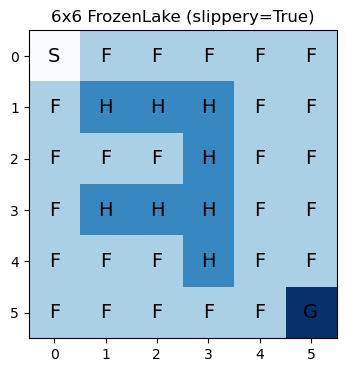

8x8 environment layout:


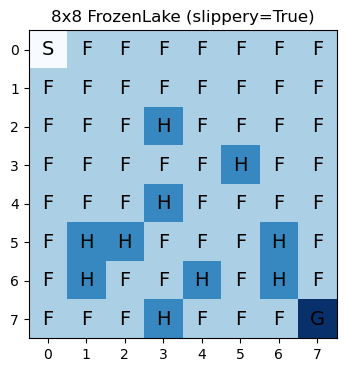

In [13]:
# Show 6x6 and 8x8 layouts once (optional, can be commented out later)
env_6 = make_frozenlake_env(desc=DESC_6X6)
print("6x6 environment layout:")
visualize_grid(env_6, "6x6 FrozenLake (slippery=True)")
env_6.close()

env_8 = make_frozenlake_env(map_name="8x8")
print("8x8 environment layout:")
visualize_grid(env_8, "8x8 FrozenLake (slippery=True)")
env_8.close()


## Reinforcement Learning Agents: Q-Learning, SARSA, and Double Q-Learning

In [ ]:

class BaseAgent:
    """
    Base class with utility for discrete tabular methods.
    All agents hold:
      - environment
      - Q-table(s)
      - learning rate (alpha)
      - discount factor (gamma)
      - epsilon (exploration rate)
    """

    def __init__(self, env, learning_rate, discount_factor, initial_epsilon):
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = initial_epsilon

        n_states = env.observation_space.n
        n_actions = env.action_space.n
        self.n_states = n_states
        self.n_actions = n_actions


class QLearningAgent(BaseAgent):
    """
    Off-policy Q-learning agent.
    Uses max_a' Q(s', a') in the update target.
    """

    def __init__(self, env, learning_rate, discount_factor, initial_epsilon):
        super().__init__(env, learning_rate, discount_factor, initial_epsilon)
        self.q_table = np.zeros((self.n_states, self.n_actions))

    def select_action(self, state: int) -> int:
        """
        Epsilon-greedy action selection.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[state]))

    def update(self, state, action, reward, next_state, done):
        """
        Q-learning update:
          Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s', a') − Q(s,a) ].
        """
        current_q = self.q_table[state, action]
        if done:
            target = reward
        else:
            max_next_q = np.max(self.q_table[next_state])
            target = reward + self.gamma * max_next_q

        self.q_table[state, action] = current_q + self.alpha * (target - current_q)


class SarsaAgent(BaseAgent):
    """
    On-policy SARSA agent.
    Uses next action chosen by current policy in the update target.
    """

    def __init__(self, env, learning_rate, discount_factor, initial_epsilon):
        super().__init__(env, learning_rate, discount_factor, initial_epsilon)
        self.q_table = np.zeros((self.n_states, self.n_actions))

    def select_action(self, state: int) -> int:
        """
        Epsilon-greedy selection from current Q-table.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[state]))

    def update(self, state, action, reward, next_state, next_action, done):
        """
        SARSA update:
          Q(s,a) ← Q(s,a) + α [ r + γ Q(s', a') − Q(s,a) ].
        """
        current_q = self.q_table[state, action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.q_table[next_state, next_action]

        self.q_table[state, action] = current_q + self.alpha * (target - current_q)


class DoubleQLearningAgent(BaseAgent):
    """
    Double Q-learning agent.
    Uses two Q-tables to reduce overestimation bias.
    """

    def __init__(self, env, learning_rate, discount_factor, initial_epsilon):
        super().__init__(env, learning_rate, discount_factor, initial_epsilon)
        self.q_table_A = np.zeros((self.n_states, self.n_actions))
        self.q_table_B = np.zeros((self.n_states, self.n_actions))

    def select_action(self, state: int) -> int:
        """
        Epsilon-greedy using the sum of Q_A and Q_B.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_sum = self.q_table_A[state] + self.q_table_B[state]
        return int(np.argmax(q_sum))

    def update(self, state, action, reward, next_state, done):
        """
        Double Q-learning update:
         - Randomly update Q_A or Q_B using the other table for the target.
        """
        if np.random.rand() < 0.5:
            # Update Q_A
            current_q = self.q_table_A[state, action]
            if done:
                target = reward
            else:
                # action that maximizes Q_A at next_state
                best_next_action = np.argmax(self.q_table_A[next_state])
                target = reward + self.gamma * self.q_table_B[next_state, best_next_action]
            self.q_table_A[state, action] = current_q + self.alpha * (target - current_q)
        else:
            # Update Q_B
            current_q = self.q_table_B[state, action]
            if done:
                target = reward
            else:
                best_next_action = np.argmax(self.q_table_B[next_state])
                target = reward + self.gamma * self.q_table_A[next_state, best_next_action]
            self.q_table_B[state, action] = current_q + self.alpha * (target - current_q)

## Epsilon Decay Schedules and Helper Functions

In [ ]:
def epsilon_exponential(episode, total_episodes, initial_epsilon, final_epsilon):
    """
    Exponential epsilon decay from initial_epsilon to final_epsilon across episodes.
    """
    if total_episodes <= 1:
        return final_epsilon
    decay_rate = np.log(final_epsilon / initial_epsilon) / (total_episodes - 1)
    eps = initial_epsilon * np.exp(decay_rate * episode)
    return max(final_epsilon, eps)

def epsilon_linear(episode, total_episodes, initial_epsilon, final_epsilon):
    """
    Linear epsilon decay from initial_epsilon to final_epsilon across episodes.
    """
    if total_episodes <= 1:
        return final_epsilon
    slope = (final_epsilon - initial_epsilon) / (total_episodes - 1)
    eps = initial_epsilon + slope * episode
    return max(final_epsilon, eps)

def moving_average(x, window_size):
    """
    Simple moving average for smoothing learning curves.
    """
    x = np.array(x)
    if len(x) < window_size or window_size <= 1:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

In [16]:
# ------------------------------------------------------------
# 4. EVALUATION FUNCTIONS (TRAINED, RANDOM, HEURISTIC)
# ------------------------------------------------------------

def evaluate_trained_agent(env, q_values, num_episodes=500, step_penalty=0.0):
    """
    Evaluate a trained agent greedily (no exploration).
    q_values can be:
      - single Q-table (QLearning or SARSA)
      - sum of two Q-tables (Double Q-learning)
    Returns success rate (fraction of episodes that reach the goal).
    """
    successes = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = int(np.argmax(q_values[state]))
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if not done and step_penalty != 0.0:
                reward += step_penalty
            state = next_state
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Trained agent success rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def evaluate_random_policy(env, num_episodes=500, step_penalty=0.0):
    """
    Random baseline: choose each action uniformly at random.
    """
    successes = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if not done and step_penalty != 0.0:
                reward += step_penalty
            state = next_state
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Random policy success rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate

def evaluate_heuristic_policy(env, num_episodes=500, step_penalty=0.0):
    """
    Simple heuristic baseline:
      - Always tries Down (1) then Right (2), alternating.
    This mimics a naive "shortest path" attempt that ignores slippage.
    """
    successes = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < 200:
            action = 1 if steps % 2 == 0 else 2  # down, right, down, right, ...
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if not done and step_penalty != 0.0:
                reward += step_penalty
            state = next_state
            steps += 1
            if done and reward > 0:
                successes += 1
    success_rate = successes / num_episodes
    print(f"Heuristic policy success rate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate


## Unified Training Loop for All RL Methods

In [ ]:
def run_experiment(
    agent_type: str,          # "q", "sarsa", "double"
    env_desc=None,
    map_name=None,
    episodes=20_000,
    learning_rate=0.1,
    discount_factor=0.99,
    initial_epsilon=1.0,
    final_epsilon=0.05,
    epsilon_schedule="exponential",  # "exponential" or "linear"
    step_penalty=-0.001,
    visualize_env=False,
    title_prefix="",
):
    """
    Run a full RL experiment:
      - Create environment (6x6 or 8x8)
      - Train one of {Q-learning, SARSA, Double Q-learning}
      - Plot training curves
      - Evaluate vs random + heuristic baselines
    """
    env = make_frozenlake_env(map_name=map_name, desc=env_desc, is_slippery=True)

    # Optional environment visualization
    if visualize_env:
        if env_desc is not None:
            env_title = "Custom 6x6 FrozenLake"
        else:
            env_title = f"{map_name} FrozenLake"
        print(f"\nEnvironment layout: {env_title}")
        visualize_grid(env, f"{env_title} (slippery=True)")

    # Select which agent to use
    if agent_type == "q":
        agent = QLearningAgent(env, learning_rate, discount_factor, initial_epsilon)
        algo_name = "Q-learning"
    elif agent_type == "sarsa":
        agent = SarsaAgent(env, learning_rate, discount_factor, initial_epsilon)
        algo_name = "SARSA"
    elif agent_type == "double":
        agent = DoubleQLearningAgent(env, learning_rate, discount_factor, initial_epsilon)
        algo_name = "Double Q-learning"
    else:
        raise ValueError("agent_type must be one of: 'q', 'sarsa', 'double'.")

    episode_rewards = []
    episode_lengths = []
    success_flags = []
    epsilons = []

    for episode in range(episodes):
        # Choose epsilon value according to selected schedule
        if epsilon_schedule == "exponential":
            epsilon = epsilon_exponential(episode, episodes, initial_epsilon, final_epsilon)
        elif epsilon_schedule == "linear":
            epsilon = epsilon_linear(episode, episodes, initial_epsilon, final_epsilon)
        else:
            raise ValueError("epsilon_schedule must be 'exponential' or 'linear'.")

        agent.epsilon = epsilon
        epsilons.append(epsilon)

        state, _ = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        # For SARSA, we need the first action before entering the loop
        if agent_type == "sarsa":
            action = agent.select_action(state)

        while not done:
            if agent_type == "sarsa":
                # SARSA: use chosen action, then choose next_action after step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                if not done and step_penalty != 0.0:
                    reward += step_penalty
                if done:
                    next_action = None
                else:
                    next_action = agent.select_action(next_state)
                agent.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
            else:
                # Q-learning / Double Q-learning
                action = agent.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                if not done and step_penalty != 0.0:
                    reward += step_penalty
                agent.update(state, action, reward, next_state, done)
                state = next_state

            total_reward += reward
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        success_flags.append(1 if total_reward > 0 else 0)

        # Print occasional progress
        if (episode + 1) % max(1, episodes // 10) == 0:
            window = min(1000, max(10, episodes // 20))
            recent_rewards = episode_rewards[-window:]
            recent_success = success_flags[-window:]
            recent_steps = episode_lengths[-window:]
            avg_reward = np.mean(recent_rewards) if recent_rewards else 0.0
            avg_success = np.mean(recent_success) if recent_success else 0.0
            avg_steps = np.mean(recent_steps) if recent_steps else 0.0

            print(
                f"[{algo_name} | Episode {episode+1}/{episodes}] "
                f"avg_reward(last {window})={avg_reward:.3f}, "
                f"success_rate={avg_success:.3f}, "
                f"avg_steps={avg_steps:.1f}, "
                f"epsilon={epsilon:.3f}"
            )

    # Plot training curves
    window = max(1, episodes // 50)
    rewards_ma = moving_average(episode_rewards, window)
    lengths_ma = moving_average(episode_lengths, window)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    map_label = "6x6 custom" if env_desc is not None else map_name
    full_title = f"{title_prefix}{algo_name} on FrozenLake ({map_label})"
    fig.suptitle(full_title, fontsize=14)

    axes[0].plot(rewards_ma)
    axes[0].set_title("Smoothed episode rewards")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Reward")

    axes[1].plot(lengths_ma)
    axes[1].set_title("Smoothed episode lengths")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Steps")

    axes[2].plot(epsilons)
    axes[2].set_title(f"Epsilon ({epsilon_schedule} decay)")
    axes[2].set_xlabel("Episode")
    axes[2].set_ylabel("Epsilon")

    plt.tight_layout()
    plt.show()

    # Prepare Q-values for evaluation
    if agent_type in ("q", "sarsa"):
        q_values = agent.q_table
    else:  # double
        q_values = agent.q_table_A + agent.q_table_B

    print("\n=== Evaluation ===")
    trained_success = evaluate_trained_agent(env, q_values, num_episodes=500, step_penalty=step_penalty)
    random_success = evaluate_random_policy(env, num_episodes=500, step_penalty=step_penalty)
    heuristic_success = evaluate_heuristic_policy(env, num_episodes=500, step_penalty=step_penalty)

    print("\nSummary comparison:")
    print(f"  {algo_name:17s}: {trained_success:.3f}")
    print(f"  Random policy     : {random_success:.3f}")
    print(f"  Heuristic policy  : {heuristic_success:.3f}")
    if random_success > 0:
        print(f"  Improvement vs random   : {trained_success / random_success:.2f}x")
    if heuristic_success > 0:
        print(f"  Improvement vs heuristic: {trained_success / heuristic_success:.2f}x")

    env.close()

    return {
        "trained_success": trained_success,
        "random_success": random_success,
        "heuristic_success": heuristic_success,
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "epsilons": epsilons,
        "algo_name": algo_name,
    }

## 6. MAIN EXPERIMENTS: 6x6 VS 8x8 (Q-LEARNING)


========== MAIN: Q-learning on 6x6 ==========
[Q-learning | Episode 4000/40000] avg_reward(last 1000)=-0.004, success_rate=0.003, avg_steps=7.6, epsilon=0.741
[Q-learning | Episode 8000/40000] avg_reward(last 1000)=0.018, success_rate=0.031, avg_steps=14.4, epsilon=0.549
[Q-learning | Episode 12000/40000] avg_reward(last 1000)=0.046, success_rate=0.063, avg_steps=17.6, epsilon=0.407
[Q-learning | Episode 16000/40000] avg_reward(last 1000)=0.116, success_rate=0.138, avg_steps=23.4, epsilon=0.302
[Q-learning | Episode 20000/40000] avg_reward(last 1000)=0.188, success_rate=0.215, avg_steps=28.0, epsilon=0.224
[Q-learning | Episode 24000/40000] avg_reward(last 1000)=0.242, success_rate=0.274, avg_steps=33.2, epsilon=0.166
[Q-learning | Episode 28000/40000] avg_reward(last 1000)=0.352, success_rate=0.388, avg_steps=36.9, epsilon=0.123
[Q-learning | Episode 32000/40000] avg_reward(last 1000)=0.417, success_rate=0.458, avg_steps=41.7, epsilon=0.091
[Q-learning | Episode 36000/40000] avg_rewa

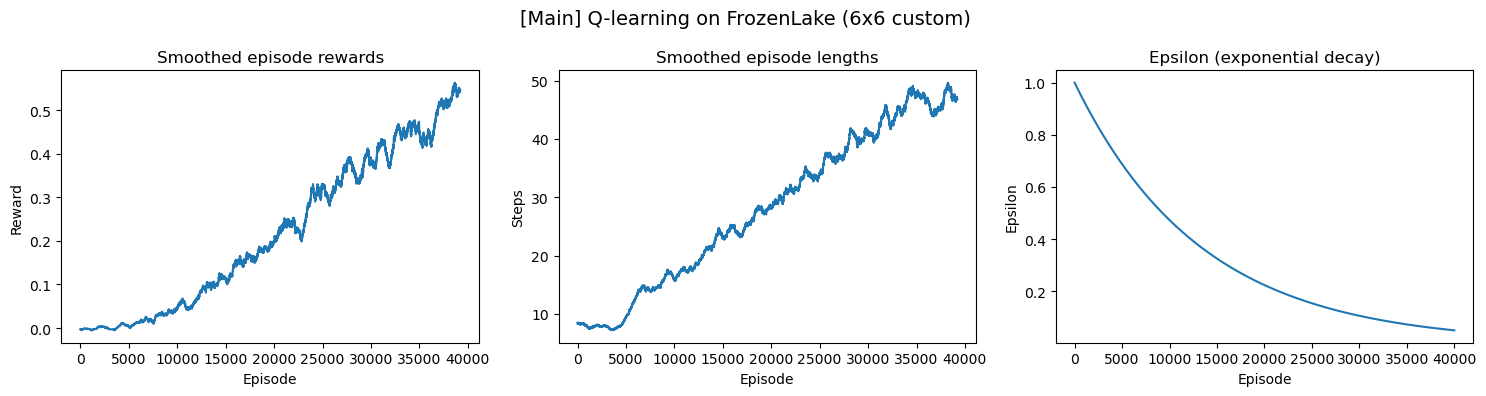


=== Evaluation ===
Trained agent success rate: 0.882 (88.2%)
Random policy success rate: 0.004 (0.4%)
Heuristic policy success rate: 0.030 (3.0%)

Summary comparison:
  Q-learning       : 0.882
  Random policy     : 0.004
  Heuristic policy  : 0.030
  Improvement vs random   : 220.50x
  Improvement vs heuristic: 29.40x

========== MAIN: Q-learning on 8x8 ==========
[Q-learning | Episode 8000/80000] avg_reward(last 1000)=-0.021, success_rate=0.004, avg_steps=26.3, epsilon=0.794
[Q-learning | Episode 16000/80000] avg_reward(last 1000)=-0.021, success_rate=0.022, avg_steps=44.2, epsilon=0.631
[Q-learning | Episode 24000/80000] avg_reward(last 1000)=-0.011, success_rate=0.036, avg_steps=47.6, epsilon=0.501
[Q-learning | Episode 32000/80000] avg_reward(last 1000)=0.023, success_rate=0.073, avg_steps=51.1, epsilon=0.398
[Q-learning | Episode 40000/80000] avg_reward(last 1000)=0.035, success_rate=0.092, avg_steps=58.2, epsilon=0.316
[Q-learning | Episode 48000/80000] avg_reward(last 1000)=0.

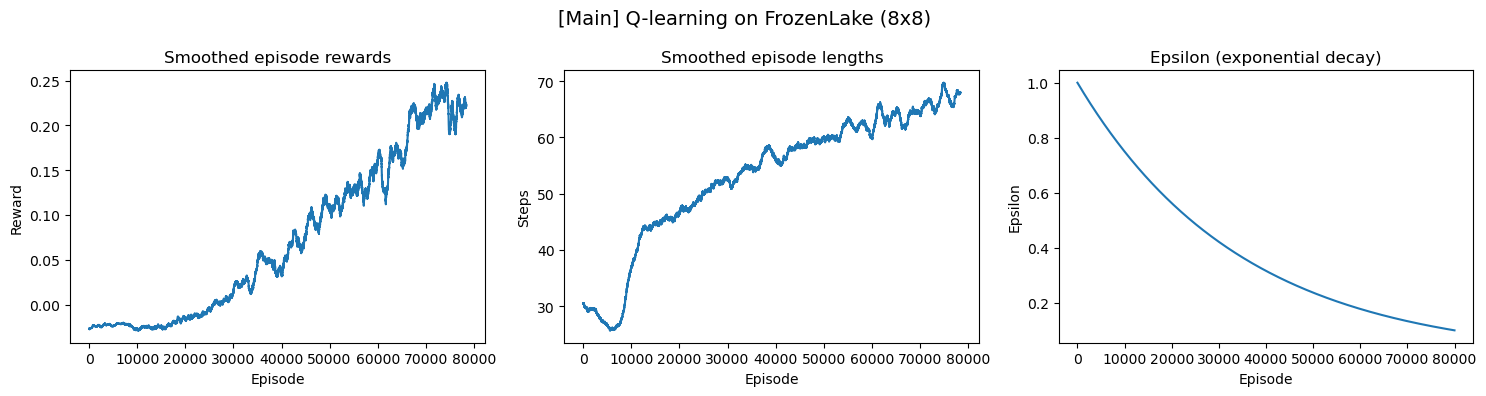


=== Evaluation ===
Trained agent success rate: 0.576 (57.6%)
Random policy success rate: 0.002 (0.2%)
Heuristic policy success rate: 0.014 (1.4%)

Summary comparison:
  Q-learning       : 0.576
  Random policy     : 0.002
  Heuristic policy  : 0.014
  Improvement vs random   : 288.00x
  Improvement vs heuristic: 41.14x

Final trained success rates (Q-learning):
6x6: 0.882
8x8: 0.576


In [ ]:
config_6x6_q = {
    "agent_type": "q",
    "env_desc": DESC_6X6,
    "map_name": None,
    "episodes": 40_000,
    "learning_rate": 0.1,
    "discount_factor": 0.99,
    "initial_epsilon": 1.0,
    "final_epsilon": 0.05,
    "epsilon_schedule": "exponential",
    "step_penalty": -0.001,
    "visualize_env": False,
    "title_prefix": "[Main] ",
}

config_8x8_q = {
    "agent_type": "q",
    "env_desc": None,
    "map_name": "8x8",
    "episodes": 80_000,
    "learning_rate": 0.05,
    "discount_factor": 0.99,
    "initial_epsilon": 1.0,
    "final_epsilon": 0.1,
    "epsilon_schedule": "exponential",
    "step_penalty": -0.001,
    "visualize_env": False,
    "title_prefix": "[Main] ",
}

print("\n========== MAIN: Q-learning on 6x6 ==========")
stats_6x6_q = run_experiment(**config_6x6_q)

print("\n========== MAIN: Q-learning on 8x8 ==========")
stats_8x8_q = run_experiment(**config_8x8_q)

print("\nFinal trained success rates (Q-learning):")
print(f"6x6: {stats_6x6_q['trained_success']:.3f}")
print(f"8x8: {stats_8x8_q['trained_success']:.3f}")

### 7. OPTIMIZATION: LINEAR VS EXPONENTIAL EPSILON (6x6)



========== OPTIMIZATION: epsilon schedules on 6x6 (Q-learning) ==========

--- Exponential epsilon decay ---
[Q-learning | Episode 4000/40000] avg_reward(last 1000)=-0.005, success_rate=0.001, avg_steps=7.1, epsilon=0.741
[Q-learning | Episode 8000/40000] avg_reward(last 1000)=0.019, success_rate=0.031, avg_steps=13.3, epsilon=0.549
[Q-learning | Episode 12000/40000] avg_reward(last 1000)=0.066, success_rate=0.082, avg_steps=17.3, epsilon=0.407
[Q-learning | Episode 16000/40000] avg_reward(last 1000)=0.098, success_rate=0.120, avg_steps=23.3, epsilon=0.302
[Q-learning | Episode 20000/40000] avg_reward(last 1000)=0.190, success_rate=0.217, avg_steps=27.9, epsilon=0.224
[Q-learning | Episode 24000/40000] avg_reward(last 1000)=0.253, success_rate=0.285, avg_steps=33.3, epsilon=0.166
[Q-learning | Episode 28000/40000] avg_reward(last 1000)=0.298, success_rate=0.335, avg_steps=38.0, epsilon=0.123
[Q-learning | Episode 32000/40000] avg_reward(last 1000)=0.412, success_rate=0.454, avg_steps=

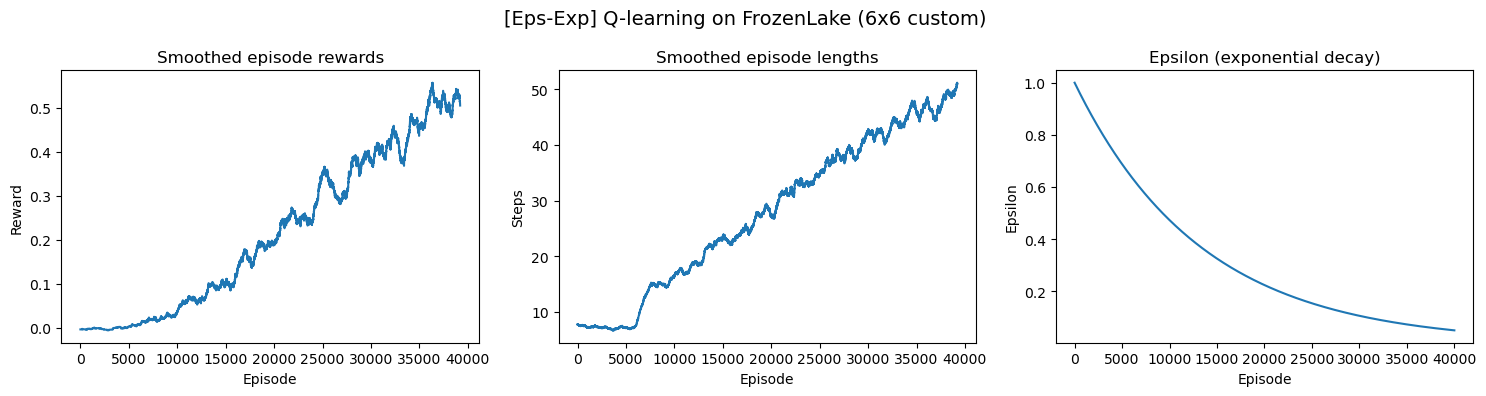


=== Evaluation ===
Trained agent success rate: 0.628 (62.8%)
Random policy success rate: 0.002 (0.2%)
Heuristic policy success rate: 0.028 (2.8%)

Summary comparison:
  Q-learning       : 0.628
  Random policy     : 0.002
  Heuristic policy  : 0.028
  Improvement vs random   : 314.00x
  Improvement vs heuristic: 22.43x

--- Linear epsilon decay ---
[Q-learning | Episode 4000/40000] avg_reward(last 1000)=-0.004, success_rate=0.003, avg_steps=8.3, epsilon=0.905
[Q-learning | Episode 8000/40000] avg_reward(last 1000)=0.001, success_rate=0.009, avg_steps=9.0, epsilon=0.810
[Q-learning | Episode 12000/40000] avg_reward(last 1000)=0.002, success_rate=0.013, avg_steps=11.6, epsilon=0.715
[Q-learning | Episode 16000/40000] avg_reward(last 1000)=0.008, success_rate=0.020, avg_steps=12.7, epsilon=0.620
[Q-learning | Episode 20000/40000] avg_reward(last 1000)=0.028, success_rate=0.043, avg_steps=15.6, epsilon=0.525
[Q-learning | Episode 24000/40000] avg_reward(last 1000)=0.047, success_rate=0.06

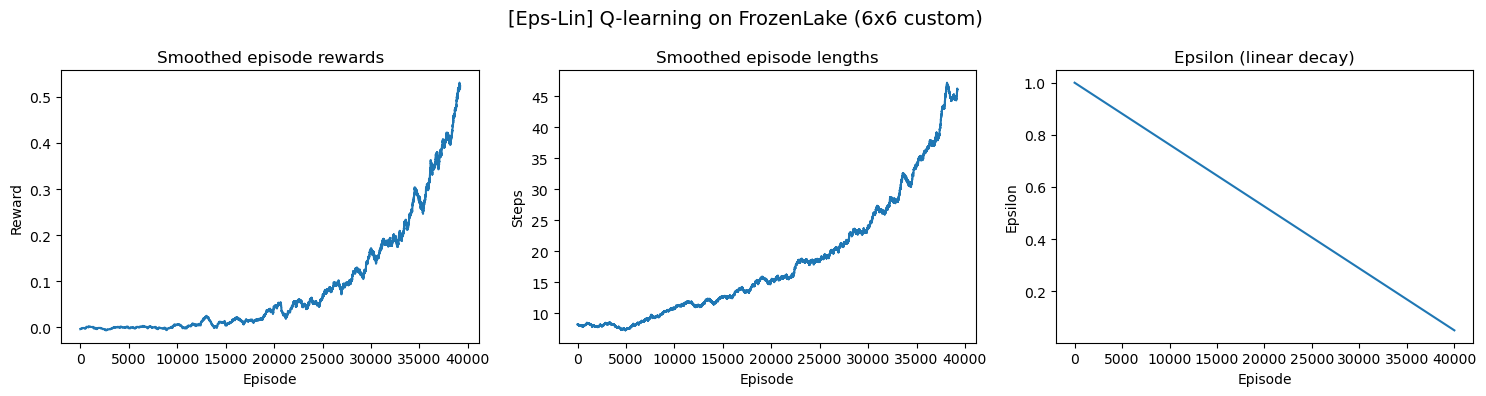


=== Evaluation ===
Trained agent success rate: 0.796 (79.6%)
Random policy success rate: 0.002 (0.2%)
Heuristic policy success rate: 0.026 (2.6%)

Summary comparison:
  Q-learning       : 0.796
  Random policy     : 0.002
  Heuristic policy  : 0.026
  Improvement vs random   : 398.00x
  Improvement vs heuristic: 30.62x

Comparison of final success rates on 6x6 (Q-learning):
Exponential epsilon: 0.628
Linear epsilon     : 0.796


In [ ]:
print("\n========== OPTIMIZATION: epsilon schedules on 6x6 (Q-learning) ==========")

config_6x6_q_exp = config_6x6_q.copy()
config_6x6_q_exp["epsilon_schedule"] = "exponential"
config_6x6_q_exp["title_prefix"] = "[Eps-Exp] "

config_6x6_q_lin = config_6x6_q.copy()
config_6x6_q_lin["epsilon_schedule"] = "linear"
config_6x6_q_lin["title_prefix"] = "[Eps-Lin] "

print("\n--- Exponential epsilon decay ---")
stats_6x6_exp = run_experiment(**config_6x6_q_exp)

print("\n--- Linear epsilon decay ---")
stats_6x6_lin = run_experiment(**config_6x6_q_lin)

print("\nComparison of final success rates on 6x6 (Q-learning):")
print(f"Exponential epsilon: {stats_6x6_exp['trained_success']:.3f}")
print(f"Linear epsilon     : {stats_6x6_lin['trained_success']:.3f}")


## 8. OPTIMIZATION: SWEEP OVER ALPHA / GAMMA (6x6, Q-LEARNING)



========== Alpha/Gamma sweep on 6x6 (Q-learning) ==========

--- Training with alpha=0.05, gamma=0.9 ---
[Q-learning | Episode 1500/15000] avg_reward(last 750)=-0.004, success_rate=0.003, avg_steps=7.4, epsilon=0.741
[Q-learning | Episode 3000/15000] avg_reward(last 750)=-0.000, success_rate=0.005, avg_steps=6.6, epsilon=0.549
[Q-learning | Episode 4500/15000] avg_reward(last 750)=-0.004, success_rate=0.001, avg_steps=6.0, epsilon=0.407
[Q-learning | Episode 6000/15000] avg_reward(last 750)=0.001, success_rate=0.005, avg_steps=5.5, epsilon=0.302
[Q-learning | Episode 7500/15000] avg_reward(last 750)=-0.001, success_rate=0.004, avg_steps=6.0, epsilon=0.224
[Q-learning | Episode 9000/15000] avg_reward(last 750)=0.003, success_rate=0.008, avg_steps=5.6, epsilon=0.166
[Q-learning | Episode 10500/15000] avg_reward(last 750)=0.002, success_rate=0.007, avg_steps=5.5, epsilon=0.123
[Q-learning | Episode 12000/15000] avg_reward(last 750)=0.005, success_rate=0.009, avg_steps=5.7, epsilon=0.091


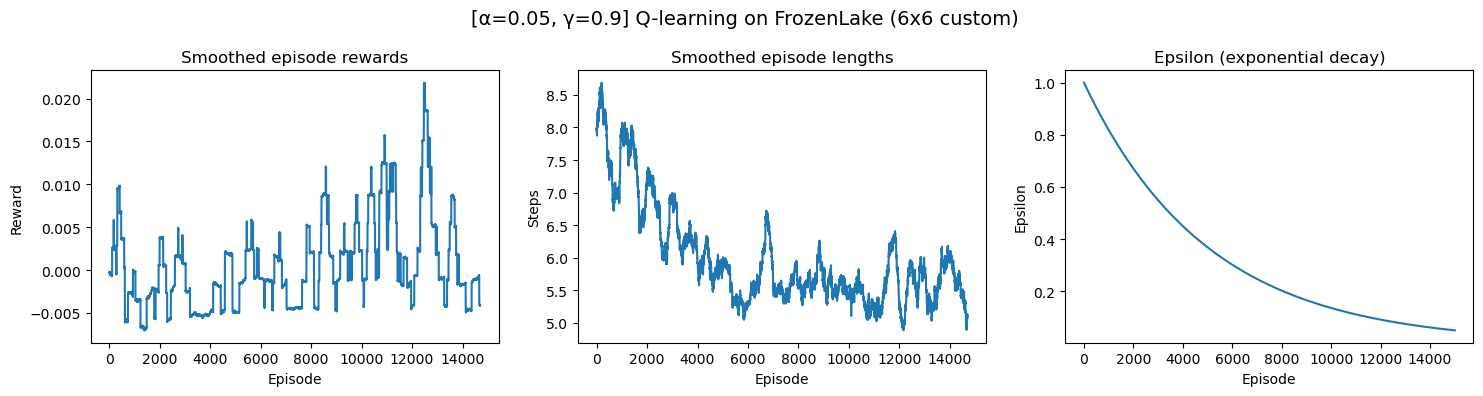


=== Evaluation ===
Trained agent success rate: 0.006 (0.6%)
Random policy success rate: 0.000 (0.0%)
Heuristic policy success rate: 0.028 (2.8%)

Summary comparison:
  Q-learning       : 0.006
  Random policy     : 0.000
  Heuristic policy  : 0.028
  Improvement vs heuristic: 0.21x

--- Training with alpha=0.05, gamma=0.99 ---
[Q-learning | Episode 1500/15000] avg_reward(last 750)=-0.001, success_rate=0.005, avg_steps=7.5, epsilon=0.741
[Q-learning | Episode 3000/15000] avg_reward(last 750)=-0.004, success_rate=0.001, avg_steps=6.4, epsilon=0.549
[Q-learning | Episode 4500/15000] avg_reward(last 750)=0.003, success_rate=0.008, avg_steps=6.2, epsilon=0.407
[Q-learning | Episode 6000/15000] avg_reward(last 750)=0.001, success_rate=0.005, avg_steps=5.8, epsilon=0.302
[Q-learning | Episode 7500/15000] avg_reward(last 750)=0.005, success_rate=0.009, avg_steps=5.6, epsilon=0.224
[Q-learning | Episode 9000/15000] avg_reward(last 750)=0.002, success_rate=0.007, avg_steps=5.5, epsilon=0.166
[Q

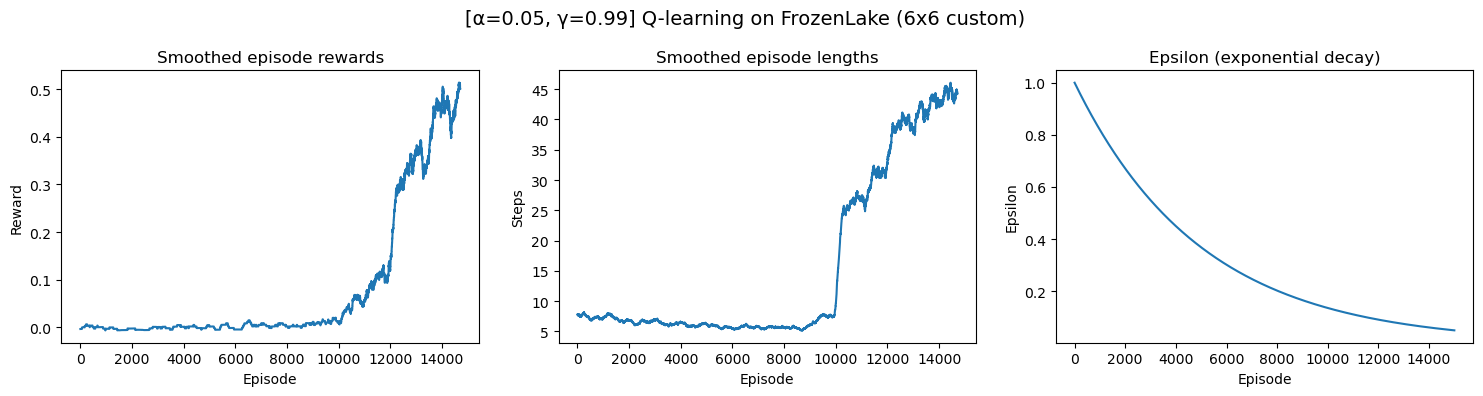


=== Evaluation ===
Trained agent success rate: 0.812 (81.2%)
Random policy success rate: 0.004 (0.4%)
Heuristic policy success rate: 0.034 (3.4%)

Summary comparison:
  Q-learning       : 0.812
  Random policy     : 0.004
  Heuristic policy  : 0.034
  Improvement vs random   : 203.00x
  Improvement vs heuristic: 23.88x

--- Training with alpha=0.2, gamma=0.9 ---
[Q-learning | Episode 1500/15000] avg_reward(last 750)=-0.005, success_rate=0.001, avg_steps=7.3, epsilon=0.741
[Q-learning | Episode 3000/15000] avg_reward(last 750)=-0.002, success_rate=0.004, avg_steps=6.6, epsilon=0.549
[Q-learning | Episode 4500/15000] avg_reward(last 750)=0.018, success_rate=0.028, avg_steps=11.5, epsilon=0.407
[Q-learning | Episode 6000/15000] avg_reward(last 750)=0.060, success_rate=0.075, avg_steps=15.4, epsilon=0.302
[Q-learning | Episode 7500/15000] avg_reward(last 750)=0.074, success_rate=0.091, avg_steps=17.3, epsilon=0.224
[Q-learning | Episode 9000/15000] avg_reward(last 750)=0.125, success_rate

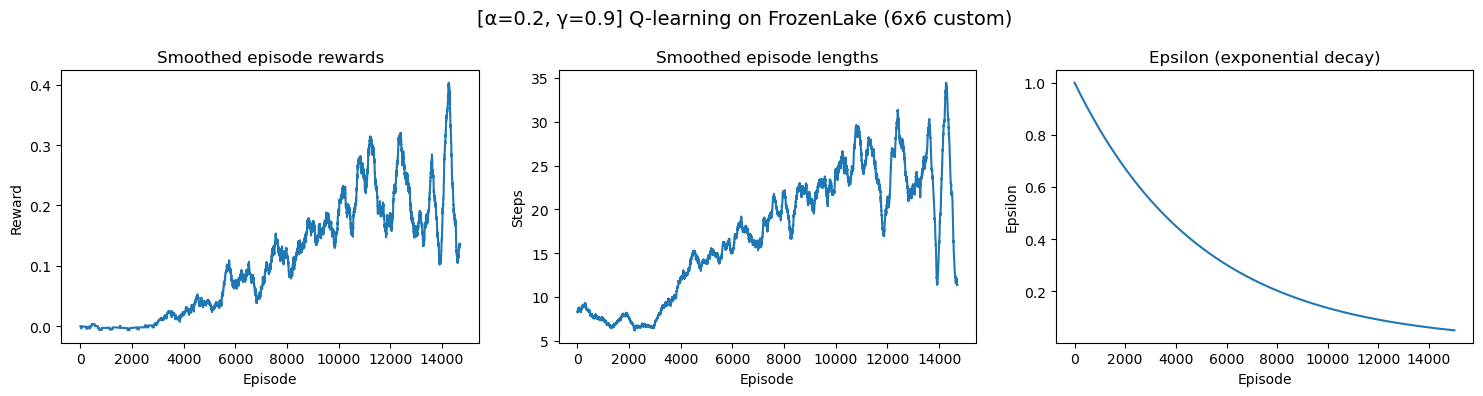


=== Evaluation ===
Trained agent success rate: 0.130 (13.0%)
Random policy success rate: 0.002 (0.2%)
Heuristic policy success rate: 0.018 (1.8%)

Summary comparison:
  Q-learning       : 0.130
  Random policy     : 0.002
  Heuristic policy  : 0.018
  Improvement vs random   : 65.00x
  Improvement vs heuristic: 7.22x

--- Training with alpha=0.2, gamma=0.99 ---
[Q-learning | Episode 1500/15000] avg_reward(last 750)=-0.002, success_rate=0.004, avg_steps=7.1, epsilon=0.741
[Q-learning | Episode 3000/15000] avg_reward(last 750)=-0.006, success_rate=0.004, avg_steps=10.6, epsilon=0.549
[Q-learning | Episode 4500/15000] avg_reward(last 750)=0.034, success_rate=0.051, avg_steps=17.4, epsilon=0.407
[Q-learning | Episode 6000/15000] avg_reward(last 750)=0.093, success_rate=0.115, avg_steps=22.4, epsilon=0.302
[Q-learning | Episode 7500/15000] avg_reward(last 750)=0.160, success_rate=0.187, avg_steps=27.6, epsilon=0.224
[Q-learning | Episode 9000/15000] avg_reward(last 750)=0.233, success_rate

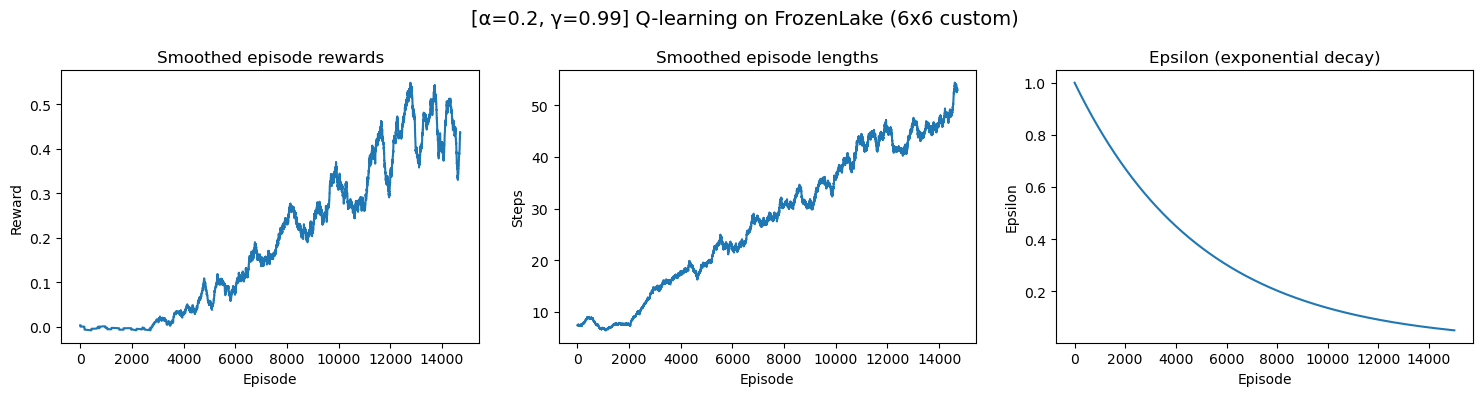


=== Evaluation ===
Trained agent success rate: 0.884 (88.4%)
Random policy success rate: 0.000 (0.0%)
Heuristic policy success rate: 0.036 (3.6%)

Summary comparison:
  Q-learning       : 0.884
  Random policy     : 0.000
  Heuristic policy  : 0.036
  Improvement vs heuristic: 24.56x

Summary of alpha/gamma sweep (success rates):
alpha=0.050, gamma=0.900 -> success=0.006
alpha=0.050, gamma=0.990 -> success=0.812
alpha=0.200, gamma=0.900 -> success=0.130
alpha=0.200, gamma=0.990 -> success=0.884


In [ ]:
def alpha_gamma_sweep(
    env_desc,
    alphas,
    gammas,
    episodes_per_run=20_000,
    epsilon_schedule="exponential",
    initial_epsilon=1.0,
    final_epsilon=0.05,
    step_penalty=-0.001,
):
    """
    Small grid search over alpha (learning rate) and gamma (discount factor) on the same map.
    This demonstrates how more "myopic" or more "far-sighted" agents behave.
    """
    results = {}
    print("\n========== Alpha/Gamma sweep on 6x6 (Q-learning) ==========")

    for alpha in alphas:
        for gamma in gammas:
            print(f"\n--- Training with alpha={alpha}, gamma={gamma} ---")
            stats = run_experiment(
                agent_type="q",
                env_desc=env_desc,
                map_name=None,
                episodes=episodes_per_run,
                learning_rate=alpha,
                discount_factor=gamma,
                initial_epsilon=initial_epsilon,
                final_epsilon=final_epsilon,
                epsilon_schedule=epsilon_schedule,
                step_penalty=step_penalty,
                visualize_env=False,
                title_prefix=f"[α={alpha}, γ={gamma}] ",
            )
            results[(alpha, gamma)] = stats["trained_success"]

    print("\nSummary of alpha/gamma sweep (success rates):")
    for (alpha, gamma), success in results.items():
        print(f"alpha={alpha:.3f}, gamma={gamma:.3f} -> success={success:.3f}")
    return results

alphas_to_test = [0.05, 0.2]
gammas_to_test = [0.90, 0.99]

sweep_results = alpha_gamma_sweep(
    env_desc=DESC_6X6,
    alphas=alphas_to_test,
    gammas=gammas_to_test,
    episodes_per_run=15_000,  # reduced for runtime
)


## 9. OPTIONAL: DEMO SARSA AND DOUBLE Q-LEARNING ON 6x6


========== OPTIONAL: SARSA on 6x6 ==========
[SARSA | Episode 3000/30000] avg_reward(last 1000)=-0.005, success_rate=0.001, avg_steps=7.0, epsilon=0.741
[SARSA | Episode 6000/30000] avg_reward(last 1000)=0.000, success_rate=0.006, avg_steps=6.8, epsilon=0.549
[SARSA | Episode 9000/30000] avg_reward(last 1000)=0.001, success_rate=0.006, avg_steps=6.1, epsilon=0.407
[SARSA | Episode 12000/30000] avg_reward(last 1000)=0.069, success_rate=0.080, avg_steps=11.6, epsilon=0.302
[SARSA | Episode 15000/30000] avg_reward(last 1000)=0.175, success_rate=0.201, avg_steps=26.9, epsilon=0.224
[SARSA | Episode 18000/30000] avg_reward(last 1000)=0.282, success_rate=0.313, avg_steps=32.4, epsilon=0.166
[SARSA | Episode 21000/30000] avg_reward(last 1000)=0.356, success_rate=0.392, avg_steps=36.7, epsilon=0.123
[SARSA | Episode 24000/30000] avg_reward(last 1000)=0.449, success_rate=0.489, avg_steps=40.9, epsilon=0.091
[SARSA | Episode 27000/30000] avg_reward(last 1000)=0.481, success_rate=0.526, avg_step

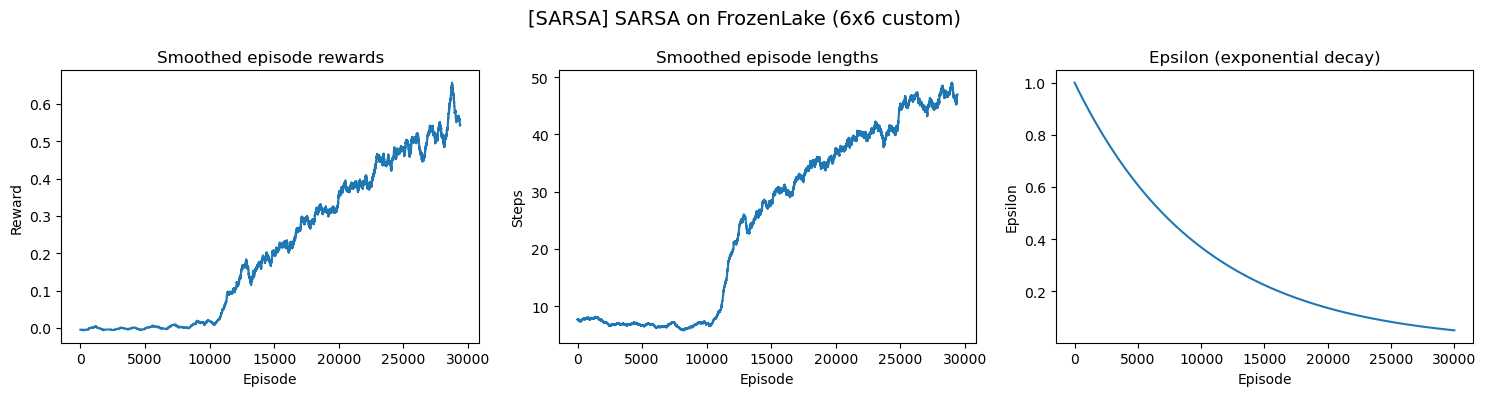


=== Evaluation ===
Trained agent success rate: 0.744 (74.4%)
Random policy success rate: 0.006 (0.6%)
Heuristic policy success rate: 0.026 (2.6%)

Summary comparison:
  SARSA            : 0.744
  Random policy     : 0.006
  Heuristic policy  : 0.026
  Improvement vs random   : 124.00x
  Improvement vs heuristic: 28.62x

========== OPTIONAL: Double Q-learning on 6x6 ==========
[Double Q-learning | Episode 3000/30000] avg_reward(last 1000)=-0.003, success_rate=0.003, avg_steps=7.2, epsilon=0.741
[Double Q-learning | Episode 6000/30000] avg_reward(last 1000)=-0.004, success_rate=0.001, avg_steps=6.5, epsilon=0.549
[Double Q-learning | Episode 9000/30000] avg_reward(last 1000)=0.000, success_rate=0.005, avg_steps=5.9, epsilon=0.407
[Double Q-learning | Episode 12000/30000] avg_reward(last 1000)=0.001, success_rate=0.006, avg_steps=5.5, epsilon=0.302
[Double Q-learning | Episode 15000/30000] avg_reward(last 1000)=0.008, success_rate=0.013, avg_steps=6.2, epsilon=0.224
[Double Q-learning | 

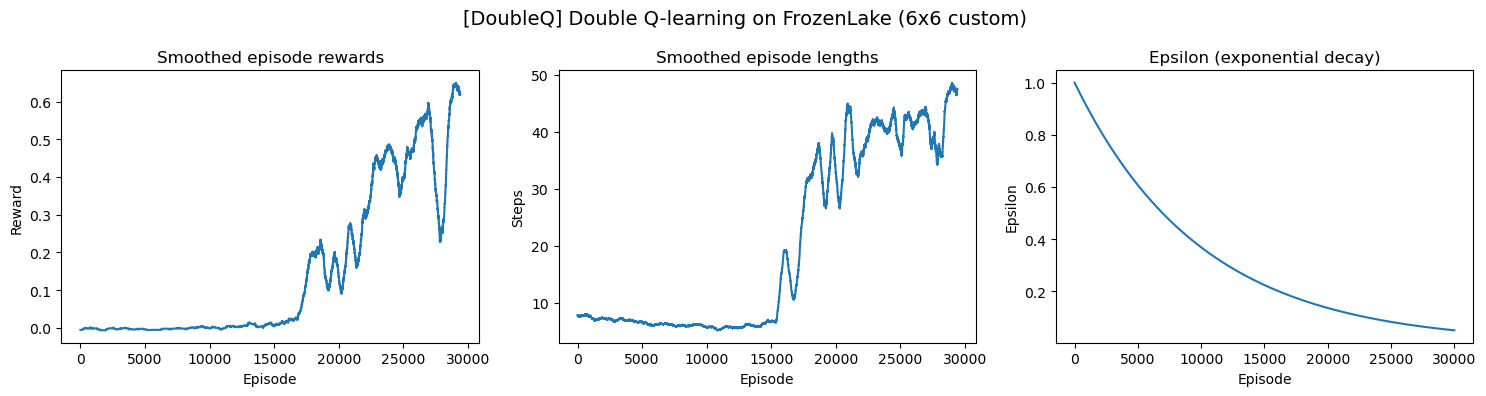


=== Evaluation ===
Trained agent success rate: 0.918 (91.8%)
Random policy success rate: 0.000 (0.0%)
Heuristic policy success rate: 0.032 (3.2%)

Summary comparison:
  Double Q-learning: 0.918
  Random policy     : 0.000
  Heuristic policy  : 0.032
  Improvement vs heuristic: 28.69x


In [ ]:
print("\n========== OPTIONAL: SARSA on 6x6 ==========")
sarsa_stats_6x6 = run_experiment(
    agent_type="sarsa",
    env_desc=DESC_6X6,
    map_name=None,
    episodes=30_000,
    learning_rate=0.1,
    discount_factor=0.99,
    initial_epsilon=1.0,
    final_epsilon=0.05,
    epsilon_schedule="exponential",
    step_penalty=-0.001,
    visualize_env=False,
    title_prefix="[SARSA] ",
)

print("\n========== OPTIONAL: Double Q-learning on 6x6 ==========")
double_stats_6x6 = run_experiment(
    agent_type="double",
    env_desc=DESC_6X6,
    map_name=None,
    episodes=30_000,
    learning_rate=0.1,
    discount_factor=0.99,
    initial_epsilon=1.0,
    final_epsilon=0.05,
    epsilon_schedule="exponential",
    step_penalty=-0.001,
    visualize_env=False,
    title_prefix="[DoubleQ] ",
)